In [24]:
# Cell 1: Setup and Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Ignore harmless warnings for cleaner output
warnings.filterwarnings('ignore')

# Configuration for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# --- Data Loading ---
print("Step 1: Loading and combining data...")
try:
    # Load individual city datasets
    delhi_df = pd.read_csv('Indian_housing_Delhi_data.csv')
    mumbai_df = pd.read_csv('Indian_housing_Mumbai_data.csv')
    pune_df = pd.read_csv('Indian_housing_Pune_data.csv')
except FileNotFoundError:
    print("Error: Make sure all three CSV files are in the same directory.")
    raise

# Add city column and combine into one DataFrame
delhi_df['city'] = 'Delhi'
mumbai_df['city'] = 'Mumbai'
pune_df['city'] = 'Pune'

df = pd.concat([delhi_df, mumbai_df, pune_df], ignore_index=True)
print(f"Data loaded and combined. Total records: {df.shape[0]}")
print("Retaining latitude/longitude for improved spatial prediction.")


Step 1: Loading and combining data...
Data loaded and combined. Total records: 13910
Retaining latitude/longitude for improved spatial prediction.


In [25]:

# Cell 2: Initial Cleaning and Feature Engineering (FIXED: Retaining Lat/Long and removing commas)

print("\nStep 2: Cleaning and standardizing features...")

# 1. Drop Unneeded Columns
# latitude and longitude are now RETAINED (removed from this list)
columns_to_drop = ['isNegotiable', 'priceSqFt', 'description', 'currency', 'verificationDate']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 2. House Size: Remove commas (CRITICAL FIX), extract numeric part, and convert to float
df['house_size'] = (df['house_size'].astype(str)
                    .str.replace(',', '', regex=False) 
                    .str.extract(r'(\d+.\d+|\d+)')
                    .astype(float))

# 3. Price: Remove commas and convert to float
df['price'] = (df['price'].astype(str)
               .str.replace(',', '', regex=False)
               .str.extract(r'(\d+)')
               .astype(float))

# 4. SecurityDeposit: Handle 'No Deposit' as 0, remove commas, and convert to float
df['SecurityDeposit'] = (df['SecurityDeposit'].astype(str)
                         .str.replace(',', '', regex=False)
                         .str.replace('No Deposit', '0')
                         .str.extract(r'(\d+)')
                         .astype(float))

# 5. BHK: Extract number of bedrooms from 'house_type' 
df['bhk'] = df['house_type'].str.extract(r'(\d+)').astype(float)
df.drop(columns=['house_type'], inplace=True, errors='ignore')

# 6. Clean Whitespace: Remove leading/trailing spaces from categorical columns
for col in ['location', 'Status']:
    df[col] = df[col].astype(str).str.strip()

# 7. Handle NaNs: Impute with median for numerical features
# num_cols now includes 'latitude' and 'longitude'
num_cols = ['price', 'house_size', 'numBathrooms', 'numBalconies', 'SecurityDeposit', 'bhk', 'latitude', 'longitude']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
    
# Drop rows where location or status might still be NaN/empty after cleaning
df.dropna(subset=['location', 'Status'], inplace=True)

print(f"\nCleaning complete. Final records: {df.shape[0]}")



Step 2: Cleaning and standardizing features...

Cleaning complete. Final records: 13910


In [26]:
# Cell 3: Critical Data Correction: Fixing house_size Outliers

print("\nStep 3: Correcting house_size outliers...")

# 1. Calculate IQR for house_size
Q1 = df['house_size'].quantile(0.25)
Q3 = df['house_size'].quantile(0.75)
IQR = Q3 - Q1
UPPER_BOUND = Q3 + 3.0 * IQR 
MIN_SIZE = 100.0 # Set a minimum practical house size

# 2. Apply Capping and Minimum Threshold
df['house_size'] = np.where(df['house_size'] < MIN_SIZE, MIN_SIZE, df['house_size'])
df['house_size'] = np.where(df['house_size'] > UPPER_BOUND, UPPER_BOUND, df['house_size'])

print(f"House Size successfully capped (min: {MIN_SIZE}, max: {UPPER_BOUND:.2f} sq ft).")




Step 3: Correcting house_size outliers...
House Size successfully capped (min: 100.0, max: 5040.00 sq ft).



Visualizing corrected correlation heatmap (including spatial features)...


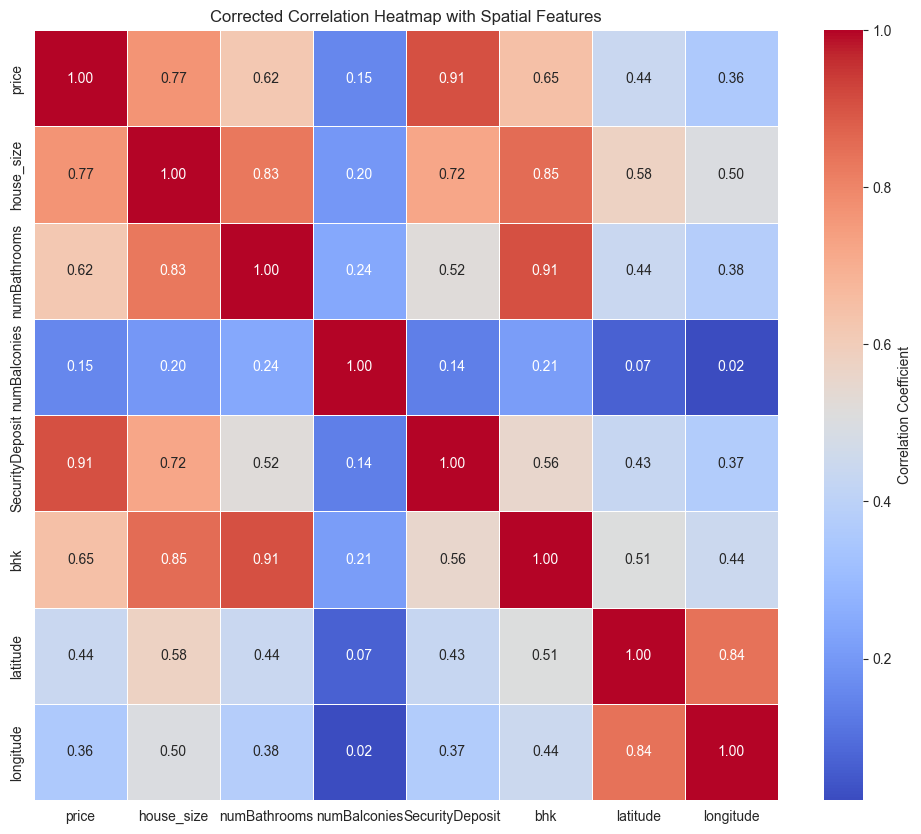

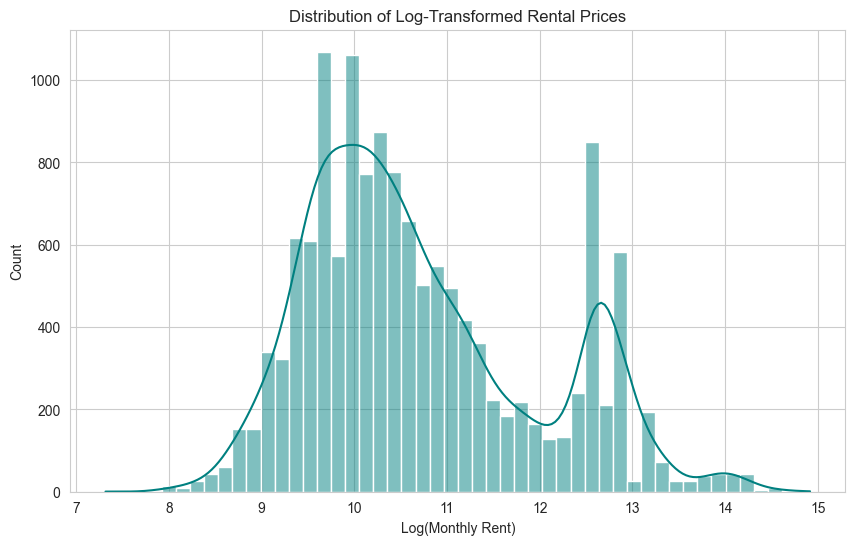

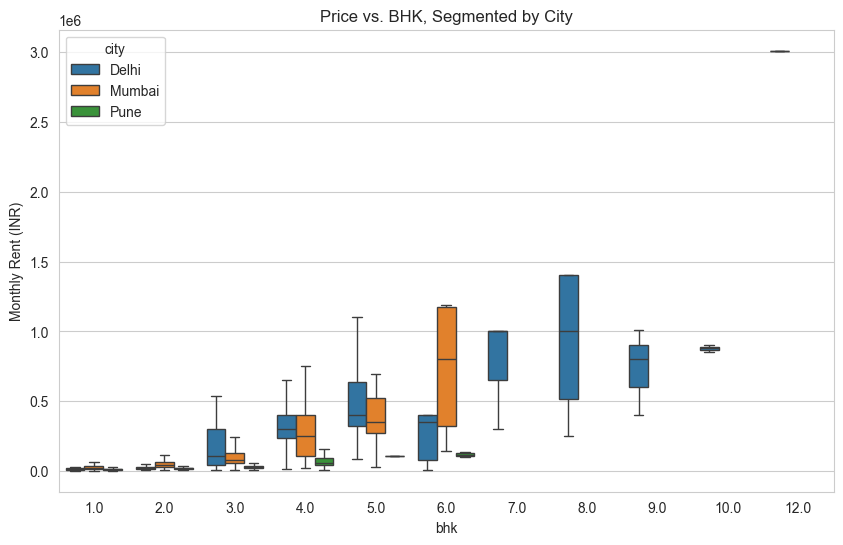

In [27]:
# Cell 4: Visualizations and Correlation Verification

# Define numerical features for correlation check (NOW including latitude and longitude)
NUMERICAL_FOR_CORR = ['price', 'house_size', 'numBathrooms', 'numBalconies', 'SecurityDeposit', 'bhk', 'latitude', 'longitude']
correlation_df = df[NUMERICAL_FOR_CORR].copy()

# --- Plot 4.1: Corrected Correlation Heatmap ---
print("\nVisualizing corrected correlation heatmap (including spatial features)...")
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Corrected Correlation Heatmap with Spatial Features')
plt.show() 

# --- Plot 4.2: Price Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['price']), kde=True, bins=50, color='teal')
plt.title('Distribution of Log-Transformed Rental Prices')
plt.xlabel('Log(Monthly Rent)')
plt.show()

# --- Plot 4.3: Price vs. BHK by City ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='bhk', y='price', hue='city', data=df, showfliers=False) 
plt.title('Price vs. BHK, Segmented by City')
plt.ylabel('Monthly Rent (INR)')
plt.show()



In [28]:
# Cell 5: Preprocessing Pipeline Definition and Data Prep

# Define feature sets for the final model: NOW INCLUDING LATITUDE AND LONGITUDE
NUMERICAL_FEATURES = ['house_size', 'numBathrooms', 'numBalconies', 'SecurityDeposit', 'bhk', 'latitude', 'longitude']
CATEGORICAL_FEATURES = ['location', 'Status'] 

# Feature Transformer
preprocessor = ColumnTransformer(
    transformers=[
        # Scale all numerical features, including spatial coordinates
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        # One-hot encode the location and status
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
    ],
    remainder='drop' 
)

print("Preprocessing pipeline defined (now including latitude and longitude).")

# Save the necessary features for the Streamlit App to use
# The app will use this file for dropdowns and coordinate lookups.
df[['city', 'location', 'Status', 'latitude', 'longitude']].drop_duplicates().to_csv('df_city_locations_and_coords.csv', index=False)
print("\nSaved 'df_city_locations_and_coords.csv' for Streamlit app.")


Preprocessing pipeline defined (now including latitude and longitude).

Saved 'df_city_locations_and_coords.csv' for Streamlit app.


In [29]:
# Cell 6: Training City-Specific Random Forest Models

CITIES = df['city'].unique()
print(f"\nStep 6: Training separate models for: {CITIES}")

# The common model definition (ensures consistent hyperparameters)
rf_model_def = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42, n_jobs=-1)

city_models = {}
evaluation_metrics = {}

for city in CITIES:
    print(f"\n--- Training Model for {city} ---")
    
    # 1. Filter Data for the Current City
    df_city = df[df['city'] == city].copy()
    
    # 2. Define X and y (Features and Log-transformed Target)
    X = df_city[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
    y = np.log1p(df_city['price']) # Log-transform the price target

    # 3. Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 4. Train the Pipeline (re-fit the preprocessor and the regressor)
    # Define the pipeline fresh for each city
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', rf_model_def)
    ]).fit(X_train, y_train)

    # 5. Evaluate the Model (on original price scale for meaningful MAE)
    y_pred_test = model.predict(X_test)
    y_test_exp = np.expm1(y_test) 
    y_pred_exp = np.expm1(y_pred_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    r2 = r2_score(y_test_exp, y_pred_exp)
    
    evaluation_metrics[city] = {'R2 Score': r2, 'MAE (INR)': mae}
    
    print(f"Test R-squared: {r2:.4f}")
    print(f"Test MAE (Mean Absolute Error): ₹ {mae:,.0f}")
    
    # 6. Save the City-Specific Model Pipeline
    model_filename = f'rf_model_{city.lower()}.pkl'
    joblib.dump(model, model_filename)
    city_models[city] = model_filename
    
    print(f"Model saved as: {model_filename}")

print("\n--- Summary of All City Model Performance ---")
for city, metrics in evaluation_metrics.items():
    print(f"City: {city} | R2: {metrics['R2 Score']:.4f} | MAE: ₹ {metrics['MAE (INR)']:,}")

print("\nProject setup complete. Run 'streamlit run app.py' next.")



Step 6: Training separate models for: ['Delhi' 'Mumbai' 'Pune']

--- Training Model for Delhi ---
Test R-squared: 0.9708
Test MAE (Mean Absolute Error): ₹ 22,151
Model saved as: rf_model_delhi.pkl

--- Training Model for Mumbai ---
Test R-squared: 0.8362
Test MAE (Mean Absolute Error): ₹ 12,010
Model saved as: rf_model_mumbai.pkl

--- Training Model for Pune ---
Test R-squared: 0.7560
Test MAE (Mean Absolute Error): ₹ 3,575
Model saved as: rf_model_pune.pkl

--- Summary of All City Model Performance ---
City: Delhi | R2: 0.9708 | MAE: ₹ 22,150.772634837744
City: Mumbai | R2: 0.8362 | MAE: ₹ 12,010.265257298459
City: Pune | R2: 0.7560 | MAE: ₹ 3,574.6557001862366

Project setup complete. Run 'streamlit run app.py' next.
